In [8]:
import sys
import os.path
sys.path.append('src/util')

import set_compiler
set_compiler.install()

import pyximport
pyximport.install()

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
sys.path.append('src')
from OnlineVariationalInference.ovi import oviLDA
from CollapsedGibbsSampler.cgs import cgsLDA
from LDAutil import Evaluation

import time

Compiling with /usr/local/bin/clang-omp


# Introduction

More and more text contents are shared on internet: news article, blog posts, user reviews... All these texts carry relevant information but the issue is how to process them. They could be used in machine learning models to refine prediction. 

For example, one popular application are the recommender systems. The goal is here to find what the users are more likely to like based on what the people similar to them liked. If we consider movies, we would like to use the synopsis, for products on online stores, we would like to use their descriptions. We could represent the text with its word counts in a [document, term] matrix. But this representation do not depict the underlying structure of the documents and their inner relationships.

One possible solution to this problem is to apply a Latent Dirichlet Allocation, a topic modeling algorithm to find the latent features of the documents. Unfortunately, these methods requires many computations for large datasets. There is one serial implementation in python (https://pypi.python.org/pypi/lda) which already takes 50 minutes to run for a small document term matrix of size (2000 docs, 10 000 words).

The goal of our project is to implement an LDA package in Python implementing two inference methods: the gibbs sampler and the online variatonnal inference. We took advantage of the Cython and Multithreading modules to build an optimized and parallel algorithm. Our deliverabe is be an open-source library, fully documented, easy to install and much faster than the current tools.

To tackle this problem, we have to deal on one hand with ninja skills in Cython and parallel design to come up with a highly efficient algorithm and on the other hand with deep knowledge of software engineering to bring the different methods together into a functionnal package.

In this report, we first provide the theoretical background needed to grasp the algorithm and explain the data we consider to test our algorithm. Then, we present the design of our package, digg deeply in the algorithm implementation and provides our performance results, in terms both of execution time and model accuracy. Lastly, we expose the possible improvements for the future.


# 1 Theory

### 1.1 LDA Model

The LDA is a three-level hierarchical Bayesian model. The basic idea is that documents are represented as random mixtures over latent topics and each topic is characterized by a distribution over words.

The generative process for a document w in a corpus D is the following:

1. Choose the topics representation: $\phi \sim$ Dir($\beta$)
* Choose the number of words: $ N \sim $ Poisson($ \xi $)
* Choose the distribution of topics: $\theta_w \sim$ Dir($\alpha_w$)
* For each of the N words:
    1. Choose a topic assignement: $z_{n,w} \sim \text{Multinomial}(\theta_w)$
	* Choose a word: $w_n \sim \text{ Multinomial}(\phi_{z_{n,w}})$



### 1.2 Inference methods

The main issue relies in computing the posterior distribution of the hidden variables given a document:

\begin{align*}
p(\theta, \mathbf{z} |\mathbf{w}, \alpha, \beta) = \frac{p(\theta, \mathbf{z}, \mathbf{w} | \alpha, \beta)}{p(\mathbf{w} | \alpha, \beta)}
\end{align*}

This distribution is intractable. As mentioned above, we used two  methods to infer it: through a Gibbs sampler or variational inference. In the first case, we are estimating the hyper parameters $\theta$ and $\phi$ with samples on the different variables. Alternatively, we chose the online variational inference method which finds the variational parameters that optimize a lower bound on the loglikelihood. 

##### 1.2.1 Gibbs sampling

##### 1.2.2 Online Variational Inference

The setup of the Variational Inference is as follows. We first approximate the true posterior by a simpler and factorised distribution:
$$q(\boldsymbol{z},\boldsymbol{\theta},\boldsymbol{\beta}) = q(\boldsymbol{z})q(\boldsymbol{\theta})q(\boldsymbol{\beta}) $$ 

where:
$$ q(z_{di} = k) = \phi_{d_{w_{di}k}} \quad q(\theta_d) = \text{Dir}(\theta_d,\gamma_d) \quad q(\beta_k) = \text{Dir}(\beta_k,\lambda_k) $$

The $\boldsymbol{\gamma}$ parameter rules the topic assignments for each document and the $\boldsymbol{\lambda}$, the topics themselves. We then minimise the KL divergence between the distribution $q$ and the true posterior $p$ like for the usual variational inference. What differs in online variational inference is that we sample a batch of document at each step and perform the E-step as if this batch constituted the entire corpus. 

We present the algorithm below:

<img src="img/ovi_pseudocode.png" width=500 height=300/>

where $\kappa \in (0.5,1]$ rules how fast we forget old values of $\tilde{\lambda}$ and $\tau_{0}$ how much weight one wants to put on the first iterations. 


### 1.3 Evaluation methods

We need a measure to evaluate the performance of our model and to tune the hyperparameters. We use perplexity on held-out data as a measure of our model fit. Perplexity is defined as the geometric mean of the log likelihood of the words in the held-out set of documents given the trained model. In our case, for each document we held out 20% of the words which constitue the test set.

\begin{align*}
	perplexity(D_{test}) & = \frac{\sum\limits_{d \in D_{test}} \log p(words)}{\sum\limits_{d \in D_{test}|d|}}\\
	perplexity(D_{test}) & = \frac{\sum\limits_{d \in D_{test}} \sum\limits_{w \in d} \log \left( \sum_{t \in topics} p(w|t)p(t|d) \right)}{\sum\limits_{d \in D_{test}|d|}}
\end{align*}



# 2 Data

### 2.1 Presentation

We chose to apply the latent dirichlet allocation on user reviews from the Yelp website. We focused only on the restaurants from a specific city (Las Vegas). The objective is to infer both the restaurants categories present in Las Vegas (using the topic distribution provided by the lda) and the categories for each restaurant (using the topics assignement of eahc restaurant).

We download the raw data made available by Yelp for its dataset challenge competition (http://www.yelp.com/dataset_challenge). For the Las Vegas restaurants, we have ~20 000 reviews of average size ~100 words, the set of unique words being larger than 50 000.


### 2.2 Processing

The dataset contains 3822 businesses, considered here as documents. Cleaning the reviews represented a significant part of this final project. We present some of the steps we followed in the process:\\

* We aggregated all the reviews about a particular business into a "super" review, in order to get a general sense of what the restaurant was about;
* We applied spelling corrections, removed common stopwords and generic words such as "table" or "restaurants";
* We attempted at only selecting common words and not adjectives in order to focus on what the venues were about and not the users' opinions (this process was done taking advantage of Spark to reduce the computing time);
* We transformed the corpus of "super reviews" into a document-term matrix that we could exploit.
* We aggregated reviews so some words may be much more used than other and we still want to take advantage of all the available information. As a result, we down scaled the words counts into the range [0, 100]. 

The processing lead to a document term matrix of size (2 000 words, 10 000 documents)


# 3 Package design

We worked hard on building a very well organized and documentation package. The documentation is provided in the readme file on the github repository : https://github.com/virgodi/plda


# 4 Implementation Details

### 4.1 OVI

The online variationnal inference implementation implies a single pass of the algorithm on each document. The only parallelisation is feasible on the loop over the documents is using mini-batch of documents and updating the topics distribution between these batch. As a result, we chose to implement a mini-batch version where the work inside the batch is divided among threads. 

We first wrote a functionnal version in Cython without using any Python library (like numpy) to be able to release the gil. To parallelise the work among threads, we needed to find an efficient combination of shared and private memories between the threads.

#### Cython code

memory view type used, taylor approximation of the digamma function

#### Multithreading

local version per thread of the temporary topics distribution. Less expensive than locks . Not possible to work on the same topics matrix with locks over words region because of the gamma update at each iteration of the inner loop, neither it is with locks over the topics because of the normalization needed to update gamma.


### 4.2 GS

details of the pseudo code, cython use and multithreading (with 2 different approaches on lock

# Result

Running a cross validation on the ideal number of topics with the ovi, show plot of perplexity 

Copy and paste a test script building LDA on the las vegas dataset with different number of threads and locks approach for gs. Plotting the time over the number of threads for OVI and for the 2 locking of GS (3 plots).



In [2]:
# Loading the data: too heavy to be on github
# Be sure to have them on local
dtm = np.load('../lv_dtm.npy').astype(int)
vocablv = np.load('../Lasvegas/lv_vocab10.npy')

In [3]:
# Cross validation on the number of topics
K = range(40, 80, 3)
model_ovi = oviLDA(num_topics=10, num_threads=8, batch_size=50)
perplexity_dict = {}
for k in K:
    model_ovi.set_topics(k)
    %time model_ovi.fit(dtm)
    perplexity_dict[k] = model_ovi.perplexity_train

CPU times: user 8.99 s, sys: 383 ms, total: 9.38 s
Wall time: 4.16 s


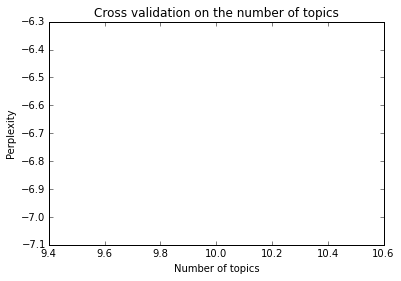

In [9]:
perp_val = sorted(perplexity_dict.items(), key=lambda x: x[0])
plt.plot([p[0] for p in perp_val], [p[1] for p in perp_val])
plt.xlabel('Number of topics')
plt.ylabel('Perplexity')

plt.title('Cross validation on the number of topics')
plt.show()

# 5 Improvements


# 6 Learnings

We need to present interestings insights we learned from the project and what we enjoyed the most...

# References

